# Домашнее задание, модуль по NLP

### Задание 1:

В папке с данными (data) расположен датасет bbc , который содержит 5 классов новостных статей (business, entertainment, politics, sport, tech). Вам необходимо реализовать следующее:

 - Обучить любой (на ваш выбор) алгоритм классификации из классических алгоритмов машинного обучения (не нейронная сеть!) и измерить метрику качества работы модели (не забываем также проверять качество на инференсе).
 - Дообучить модель DistillBert для многоклассовой классификации и проверить также качество работы алгоритма (н забываем проверять качество на инференсе). Похожий код был продемонстрирован на лекции, думаем головой, не копипастите, есть нюансы в данной задаче.
 - Оформить оба решения в пайплайны. Отдаем новости – получаем метку класса и вероятность. Соскрапить или собрать вручную по пять свежих новостей с ресурса (https://www.bbc.com/news - ссылки на новости прикрепить в ноутбуке) для каждого из классов и прогнать на них пайплайны.  Получить результаты инференса пайплайнов, и оценить какое из решений лучше.


In [1]:
import os
import re
import string
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import requests
from bs4 import BeautifulSoup
from torch.utils.data import Dataset
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import TfidfModel, LdaModel, CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from gensim import corpora, models, similarities

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy

In [3]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package punkt to /Users/anetta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anetta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/anetta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/anetta/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.3 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Загрузка данных</h4>
</div>

Загрузим тексты из файлов и присвоим метки классов на основе названий папок.

In [4]:
zip_path = 'bbc.zip'
data_path = 'bbc'

In [5]:
# Разархивируем bbc.zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

In [6]:
# Название классов новостных статей
lebels = os.listdir(data_path)

In [7]:
lebels

['entertainment', 'business', 'sport', 'politics', 'tech']

In [8]:
def load_data(path):
    """Loads text and labels from categorized directories.
    Params:
        path: str
            Path to original data
    Returns:
        pd.DataFrame: 
            Dataset with text and labels
    """
    texts = []
    labels = []
    for category in os.listdir(path):
        category_path = os.path.join(path, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)
                with open(file_path, 'r', encoding='latin-1') as file:
                    texts.append(file.read())
                    labels.append(category)
    return pd.DataFrame({'text': texts, 'label': labels})

In [9]:
# Загрузка данных
df = load_data(data_path)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2221 non-null   object
 1   label   2221 non-null   object
dtypes: object(2)
memory usage: 34.8+ KB


In [11]:
df.head()

,text,label
0,Musicians to tackle US red tape\n\nMusicians' ...,entertainment
1,"U2's desire to be number one\n\nU2, who have w...",entertainment
2,Rocker Doherty in on-stage fight\n\nRock singe...,entertainment
3,Snicket tops US box office chart\n\nThe film a...,entertainment
4,Ocean's Twelve raids box office\n\nOcean's Twe...,entertainment


<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Предобработка данных</h4>
</div>

In [12]:
# Пригодится для токенизации
nlp = spacy.load("en_core_web_sm")

In [13]:
def preprocess_text(text):
    """
    Cleans the text by removing punctuation, stop words, and performing lemmatization 
    while preserving abbreviations, converts text to lowercase.

    Parameters:
    text (str): The input text to be processed.
    exceptions (set): A set of words (abbreviations) to be preserved.

    Returns:
    str: The cleaned and lemmatized text.
    """
    # Убираем мусорные символы кодировки
    text = text.encode("latin1").decode("utf-8", "ignore")

    # Обрабатываем текст 
    doc = nlp(text)
    tokens = []
    
    for token in doc:
        # Убираем стоп-слова, именованые сущности и токены с цифрами
        if not token.is_stop and token.is_alpha and not token.ent_type_: 
            tokens.append(token.lemma_)

    # Собираем текст
    cleaned_text = " ".join(tokens)
    # Удаляем знаки препинания 
    cleaned_text = cleaned_text.translate(str.maketrans("", "", string.punctuation))
    # Убираем лишние пробелы
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  
    return cleaned_text.lower()

In [14]:
df["clean_text"] = df["text"].apply(lambda x: preprocess_text(x))

Рассмотрим результат:

In [15]:
df.head()

,text,label,clean_text
0,Musicians to tackle US red tape\n\nMusicians' ...,entertainment,musician tackle red tape musicians group tackl...
1,"U2's desire to be number one\n\nU2, who have w...",entertainment,desire number win prestigious hit stubbornly c...
2,Rocker Doherty in on-stage fight\n\nRock singe...,entertainment,stage fight rock singer involve fight band gui...
3,Snicket tops US box office chart\n\nThe film a...,entertainment,snicket top box office chart film adaptation n...
4,Ocean's Twelve raids box office\n\nOcean's Twe...,entertainment,raid box office crime caper sequel star go str...


In [16]:
df.text[0]

'Musicians to tackle US red tape\n\nMusicians\' groups are to tackle US visa regulations which are blamed for hindering British acts\' chances of succeeding across the Atlantic.\n\nA singer hoping to perform in the US can expect to pay $1,300 (Â£680) simply for obtaining a visa. Groups including the Musicians\' Union are calling for an end to the "raw deal" faced by British performers. US acts are not faced with comparable expense and bureaucracy when visiting the UK for promotional purposes.\n\nNigel McCune from the Musicians\' Union said British musicians are "disadvantaged" compared to their US counterparts. A sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "If you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says Mr McCune.\n\n"The US is the world\'s biggest music market, which means something has to be done abo

In [17]:
df.clean_text[0]

'musician tackle red tape musicians group tackle visa regulation blame hinder act chance succeed singer hope perform expect pay simply obtain visa include call end raw deal face performer act face comparable expense bureaucracy visit promotional purpose say musician disadvantaged compare counterpart sponsor petition behalf form amount page musician face tough regulation athlete journalist mistake form risk ban ability career say mr world big music market mean creaky bureaucracy say mr current situation prevent act maintain momentum develop add stance endorse artist face uphill struggle succeed thank tough visa requirement see impractical general secretary say imagine orchestra orkneys member travel visa process market see holy grail benchmark success go fight important market like add department media culture sport spokeswoman say aware people experience problem work embassy record industry spokesman say aware entertainer require visa time specific visa process application speedily awa

 - Произвели леммантизацию текста.
 - Удалили знаки препинания.
 - Привели текст к нижнему регистру.
 - Удалили стоп-слова.
 - Удалили именованные сущности.
 - Убрали не буквенные слова.

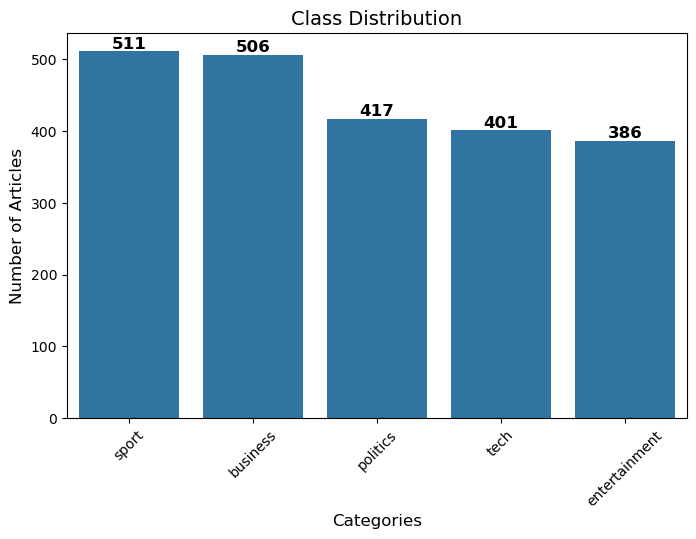

In [18]:
# Визуализация распределения классов
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values)
plt.title('Class Distribution', fontsize=14)
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=45)

# Подписи
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.show()

Видим, что классы распределены не совсем равномерно.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> SVM.</h4>
</div>

Разделим выборку на обучающую и тестовую.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["label"], test_size=0.2, random_state=42)

Используем TF-IDF векторизацию для преобразования текста в числовой формат и выбираем SVM из классических алгоритмов.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Подбор гиперпараметров.</h4>
</div>

In [20]:
# Определение пайплайна TF-IDF векторизация и SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(probability=True))
])

In [21]:
# Сетка гиперпараметров
param_grid = {
    # Подбор параметров для TF-IDF
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Используем униграммы, биграммы, триграммы
    'tfidf__min_df': [1, 3, 5, 6],  # Минимальная частота слова

    # Подбор параметров для SVM
    'svm__C': [1, 10],  # Коэффициент регуляризации
}

In [22]:
# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'tfidf__min_df': [1, 3, 5, 6],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=1)

In [23]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)

Лучшие параметры: {'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Лучшая точность: 0.971851558790948


<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Обучение модели.</h4>
</div>

In [24]:
pipeline_svm = make_pipeline(
    TfidfVectorizer(ngram_range=(1,1), min_df=5),
    SVC(kernel='linear', probability=True, C=10, class_weight='balanced')
)

pipeline_svm.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2))),
                ('svc',
                 SVC(C=10, class_weight='balanced', kernel='linear',
                     probability=True))])

In [25]:
y_pred = pipeline_svm.predict(X_test)

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Оценка качества модели.</h4>
</div>

In [26]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

In [27]:
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9843


In [28]:
pd.DataFrame(report).T

,precision,recall,f1-score,support
business,0.969697,0.989691,0.979592,97.00000
entertainment,0.987952,0.987952,0.987952,83.00000
politics,0.986842,0.974026,0.980392,77.00000
sport,1.000000,0.989899,0.994924,99.00000
tech,0.977528,0.977528,0.977528,89.00000
accuracy,0.984270,0.984270,0.984270,0.98427
macro avg,0.984404,0.983819,0.984078,445.00000
weighted avg,0.984376,0.984270,0.984288,445.00000


###### Выводы по метрикам:
 - <b>Accuracy</b> = 98.43% значит, что SVM модель почти безошибочно классифицирует статьи - это высокая общая точность.
 - <b>Precision (Точность) и Recall (Полнота)</b> для всех категорий находятся выше 96% и 97%, это говорит о хорошем распознавании всех классов.
 - <b>F1-score</b> выше 97% по всем классам, что подтверждает хорошую сбалансированность модели.
 - <b>support</b> - это количество примеров в классах, оно разное, но нет сильного дисбаланса.
 - <b>Macro Avg и Weighted Avg</b>: разница между макро и взвешенными средними практически отсутствует, значит нет сильного дисбаланса классов.

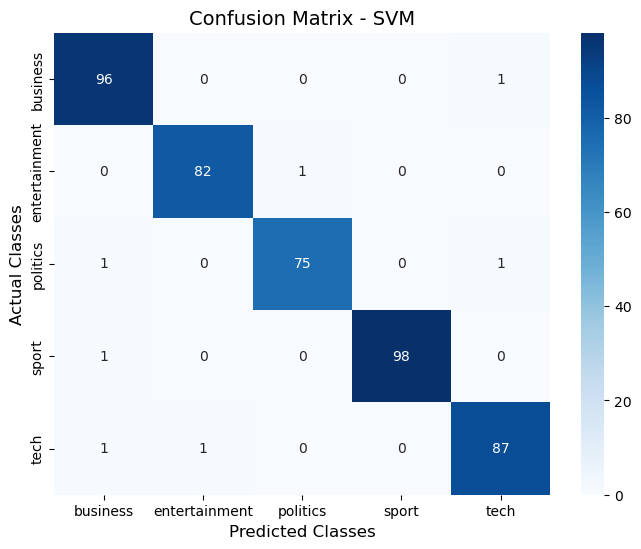

In [29]:
#Построим Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline_svm.classes_)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                 xticklabels=pipeline_svm.classes_, 
                 yticklabels=pipeline_svm.classes_)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("Actual Classes", fontsize=12)
plt.title("Confusion Matrix - SVM", fontsize=14)
plt.show()

#### Вывод по матрице ошибок:
 - Хорошая точность модели – большинство классов правильно классифицируются.
 - tech (87 правильных, 2 ошибки 1 - с business и 1 - entertainment). Возможно статьи о технологиях могут упоминать бизнес или шоу-бизнес.
 - politics (75 правильных, 2 ошибки 1 - с business и 1 - tech). Возможно политические статьи могут касаться экономики или цифровых законов.
 - business (96 правильных, 1 ошибка с tech). Возможно некоторые статьи могут быть про стартапы или IT-компании.

#### Общий вывод:
- Модель SVM показывает отличные результаты и почти не допускает ошибок.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Дообучение модели DistillBert для многоклассовой классификации.</h4>
</div>

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
# Токенизатор DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [32]:
# Токенизация данных
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

Преобразуем данные

In [33]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [34]:
label_map = {'entertainment': 0, 'business': 1, 'sport': 2, 'politics': 3, 'tech': 4}

In [35]:
y_train_enc = [label_map[label] for label in y_train]
y_test_enc = [label_map[label] for label in y_test]

In [36]:
train_dataset = NewsDataset(train_encodings, y_train_enc)
test_dataset = NewsDataset(test_encodings, y_test_enc)

In [37]:
# Модель DistilBERT для классификации
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_map))
model.save_pretrained("distilbert_news_model")
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


В попытках подобрать параметры, что б превзайти метрики SVM, автоматизировать не хочется, долго ждать:
 - num_train_epochs=3  ->  Accuracy (DistilBERT): 0.9640
 - num_train_epochs=5  ->  Accuracy (DistilBERT): 0.9730
 - num_train_epochs=7  ->  Accuracy (DistilBERT): 0.9708
 - learning_rate=3e-5,
 - num_train_epochs=5  ->  Accuracy (DistilBERT): 0.9618
 - learning_rate=1e-5,
 - num_train_epochs=5  ->  Accuracy (DistilBERT): 0.9685

In [38]:
# Настройки обучения
training_args = TrainingArguments(
    num_train_epochs=5,
    output_dir="./distilbert_news",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True
)

In [39]:
# Инициализация Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [40]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.114200,0.139152
2,0.055600,0.127877
3,0.018900,0.124711
4,0.000800,0.134536
5,0.000700,0.133024


TrainOutput(global_step=1110, training_loss=0.09091900841098044, metrics={'train_runtime': 646.4485, 'train_samples_per_second': 13.737, 'train_steps_per_second': 1.717, 'total_flos': 1176373433548800.0, 'train_loss': 0.09091900841098044, 'epoch': 5.0})

In [41]:
y_pred_bert = trainer.predict(test_dataset).predictions.argmax(axis=1)

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Оценка качества модели DistillBert.</h4>
</div>

In [42]:
accuracy_bert = accuracy_score(y_test_enc, y_pred_bert)

In [43]:
label_map_inv = {v: k for k, v in label_map.items()}

In [44]:
label_map_inv

{0: 'entertainment', 1: 'business', 2: 'sport', 3: 'politics', 4: 'tech'}

In [45]:
y_bert_test = [label_map_inv[label] for label in y_test_enc]
y_bert_pred = [label_map_inv[label] for label in y_pred_bert]

In [46]:
report_bert = classification_report(y_bert_test, y_bert_pred)

In [47]:
print(f"Accuracy (DistilBERT): {accuracy_bert:.4f}")

Accuracy (DistilBERT): 0.9775


In [48]:
print(report_bert)

               precision    recall  f1-score   support

     business       0.97      0.96      0.96        97
entertainment       0.99      0.99      0.99        83
     politics       0.97      0.97      0.97        77
        sport       1.00      1.00      1.00        99
         tech       0.96      0.97      0.96        89

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



#### Выводы по метрикам:
 - <b>Accuracy</b> = 97,75% значит, что модель почти безошибочно классифицирует статьи - это высокая общая точность, немного хуже SVM.
 - <b>Precision</b> (Точность) и <b>Recall</b> (Полнота) для всех категорий находятся выше 96%, это говорит о хорошем распознавании всех классов как и SVM.
 - <b>F1-score</b> выше 96% по всем классам, что подтверждает хорошую сбалансированность модели.

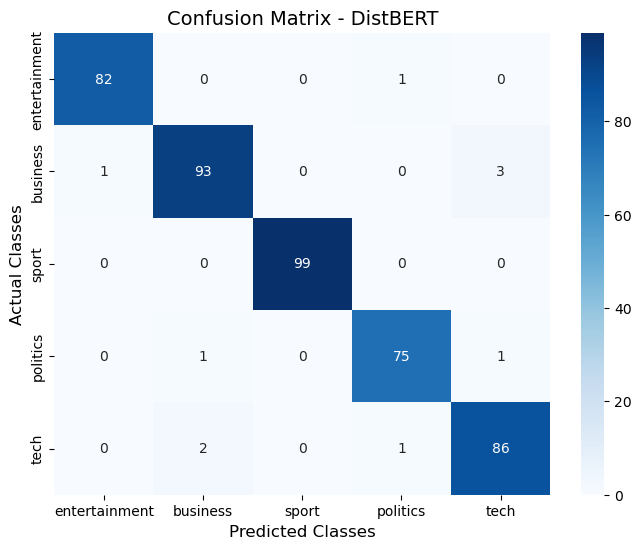

In [49]:
#Построим Confusion Matrix
cm = confusion_matrix(y_bert_test, y_bert_pred, labels=lebels)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lebels, yticklabels=lebels)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("Actual Classes", fontsize=12)
plt.title("Confusion Matrix - DistBERT", fontsize=14)
plt.show()

#### Вывод:
 - Получили похожие ошибки, как в svm.
 - У DistillBert метрики не лучше, чем у svm.
 - DistillBert работает медленнее.

<div style="background-color: powderblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Сбор свежих статей.</h4>
</div>

Выберем по пять статей на каждую из тем.

In [50]:
entertainment = [
    'https://www.bbc.com/news/articles/c4g007jjlyqo',
    'https://www.bbc.com/news/articles/cgkmmkyrl0vo',
    'https://www.bbc.com/news/articles/cqjd051z5ejo',
    'https://www.bbc.com/culture/article/20250227-10-of-the-best-films-to-watch-this-march',
    'https://www.bbc.com/culture/article/20250228-oscars-2025-who-will-win-and-who-should'
]

In [51]:
business = [
    'https://www.bbc.com/news/articles/cedll3282qzo',
    'https://www.bbc.com/news/articles/clydd7zeye7o', 
    'https://www.bbc.com/news/articles/ce8yy3wpn6eo',
    'https://www.bbc.com/news/articles/c4g7xn9y64po',
    'https://www.bbc.com/news/articles/ce980m2xv30o'
]

In [52]:
tech = [
    'https://www.bbc.com/news/articles/c5y0r8wdk62o',
    'https://www.bbc.com/news/articles/cn7vxlrvxyeo',
    'https://www.bbc.com/news/articles/cy877gydn48o',
    'https://www.bbc.com/future/article/20250228-5-youtube-videos-that-changed-the-way-we-think-about-ourselves',
    'https://www.bbc.com/news/articles/cgm18g19013o'
]

In [53]:
sport = [
    'https://www.bbc.com/sport/football/articles/c70w5q4kzkvo',
    'https://www.bbc.com/sport/football/articles/cjry7dj9v2po',
    'https://www.bbc.com/sport/football/articles/c9dej12zezno',
    'https://www.bbc.com/sport/athletics/articles/c3rn8qq2elxo',
    'https://www.bbc.com/sport/golf/articles/ce8vje3ldypo'
]

In [54]:
politics = [
    'https://www.bbc.com/news/articles/c7988r3q1p2o',
    'https://www.bbc.com/news/articles/cpv44982jlgo',
    'https://www.bbc.com/news/articles/cn9v1lzwqn7o',
    'https://www.bbc.com/news/articles/c981lr84013o',
    'https://www.bbc.com/news/articles/crmj298x7ypo'
]

In [55]:
bbc_val = {
    'entertainment': entertainment,
    'business': business,
    'tech': tech,
    'sport': sport,
    'politics': politics
}

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Сохранение новых статей.</h4>
</div>

In [56]:
def save_article_text(url, filename):
        """Fetches the main content and title of a news article from a given URL and saves them to a .txt file.
        Params:
            url: str
                Article url
            filename: str
                Path to save text
        """
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Находим и читаем заголовок
            title = soup.find('h1')
            title_text = title.get_text().strip() if title else ''
            
            # Читаем статью
            article_body = soup.find('article')
            if article_body:
                paragraphs = article_body.find_all('p')
                article_text = '\n'.join([p.get_text() for p in paragraphs])
                
                # Сохраняем
                with open(filename, 'w', encoding='utf-8') as file:
                    file.write(title_text)
                    file.write(article_text)
                print(f"Article saved successfully to {filename}")
            else:
                print("Fail.")
        else:
            print("Fail.")

In [57]:
# Сохраним в папку с аналогичной структурой исходным данным
for key in bbc_val.keys():
    os.makedirs(f'validation/{key}', exist_ok=True)
    for i in range(0, len(bbc_val[key])):
        save_article_text( url = bbc_val[key][i], filename = f'validation/{key}/{i}.txt')

Article saved successfully to validation/entertainment/0.txt
Article saved successfully to validation/entertainment/1.txt
Article saved successfully to validation/entertainment/2.txt
Article saved successfully to validation/entertainment/3.txt
Article saved successfully to validation/entertainment/4.txt
Article saved successfully to validation/business/0.txt
Article saved successfully to validation/business/1.txt
Article saved successfully to validation/business/2.txt
Article saved successfully to validation/business/3.txt
Article saved successfully to validation/business/4.txt
Article saved successfully to validation/tech/0.txt
Article saved successfully to validation/tech/1.txt
Article saved successfully to validation/tech/2.txt
Article saved successfully to validation/tech/3.txt
Article saved successfully to validation/tech/4.txt
Article saved successfully to validation/sport/0.txt
Article saved successfully to validation/sport/1.txt
Article saved successfully to validation/sport/2.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> SVM.</h4>
</div>

Соберем все в класс для загрузки и предобработки данных.

In [58]:
class BBCTextProcessor:
    def __init__(self):
        #self.zip_path = zip_path
        self.extract_path = zip_path.replace(".zip", "")  # Папка для распаковки
        self.nlp = spacy.load("en_core_web_sm")  # Загрузка модели spaCy
        
    def extract_files(self, zip_path):
        """Extract files from zip.
        Params:
            zip_path: str
                Path to zip-file.
        """
        self.zip_path = zip_path
        self.extract_path = zip_path.replace(".zip", "")
        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            zip_ref.extractall()

    def load_data(self, extract_path):
        """Loads text and labels from categorized directories.
        Params:
            path: str
                Path to original data
        Returns:
            pd.DataFrame: 
                Dataset with text and labels
        """
        texts = []
        labels = []
        self.extract_path = extract_path
        for category in os.listdir(self.extract_path):
            category_path = os.path.join(self.extract_path, category)
            if os.path.isdir(category_path):
                for filename in os.listdir(category_path):
                    file_path = os.path.join(category_path, filename)
                    with open(file_path, 'r', encoding='latin-1') as file:
                        texts.append(file.read())
                        labels.append(category)
        return pd.DataFrame({'text': texts, 'label': labels})

    def preprocess_text(self, text):
        """
        Cleans the text by removing punctuation, stop words, and performing lemmatization 
        while preserving abbreviations, converts text to lowercase.
    
        Parameters:
        text (str): The input text to be processed.
        exceptions (set): A set of words (abbreviations) to be preserved.
    
        Returns:
        str: The cleaned and lemmatized text.
        """
        # Убираем мусорные символы 
        text = text.encode("latin1").decode("utf-8", "ignore")
    
        # Обрабатываем текст
        doc = nlp(text)
        tokens = []
        
        for token in doc:
            # Убираем стоп-слова
            if not token.is_stop and token.is_alpha and not token.ent_type_: #or token.text in string.punctuation: 
                tokens.append(token.lemma_)
    
        # Собираем текст
        cleaned_text = " ".join(tokens)
        # Удаляем знаки препинания 
        cleaned_text = cleaned_text.translate(str.maketrans("", "", string.punctuation))
        # Убираем лишние пробелы
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  
        return cleaned_text.lower()

    def process(self, path):
        """Load data and prepare tetxts.
        Params:
            path: str
                Path to original data
        Returns:
            DataFrame with clean texts
        """
        self.extract_files(path)
        df = self.load_data(self.extract_path)

        # Применяем очистку текста
        df["clean_text"] = df["text"].apply(lambda x: self.preprocess_text(x))

        return df

In [59]:
text_processor = BBCTextProcessor()

In [60]:
df = text_processor.process('bbc.zip')

In [61]:
df.head(3)

,text,label,clean_text
0,Musicians to tackle US red tape\n\nMusicians' ...,entertainment,musician tackle red tape musicians group tackl...
1,"U2's desire to be number one\n\nU2, who have w...",entertainment,desire number win prestigious hit stubbornly c...
2,Rocker Doherty in on-stage fight\n\nRock singe...,entertainment,stage fight rock singer involve fight band gui...


Соберем в один класс классификацию новостей с SVM

In [62]:
class NewsClassifier:
    """
    News classificator with SVM and TF-IDF vectorization.
    """
    
    def __init__(self):
        self.pipeline = Pipeline([
            ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=5)),
            ("classifier", SVC(kernel='linear', probability=True, C=10, 
                               class_weight='balanced'))
        ])
        self.is_trained = False
        
    def clean_text(self, text):
        """Cleans text by converting to lowercase, removing digits, punctuation.
        Params:
            text: str
                Original text
        Returns:
            str:
                Clean text
        """
        text_processor = BBCTextProcessor()
        text = text_processor.preprocess_text(text)
        return text
    
    def train(self, df, feature, target):
        """Trains the classifier with given training data.
        Params:
            X_train: pandas.core.series.Series
                Articles texts for train.
            y_train: pandas.core.series.Series
                Lables target
        """
        X_train, X_test, y_train, y_test = train_test_split(df[feature], df[target], 
                                                            test_size=0.2, random_state=42)
        self.pipeline.fit(X_train, y_train)
        self.is_trained = True
        
    def predict(self, texts):
        """Predicts the class and probability for given news articles.
        Params:
            texts: pandas.core.series.Series
                Articles texts for predict
        Returns:
            pd.DataFrame
                Predicted labels
        """
        cleaned_texts = [self.clean_text(text) for text in texts]
        predictions = self.pipeline.predict(cleaned_texts)
        probabilities = self.pipeline.predict_proba(cleaned_texts)
        class_probabilities = probabilities.max(axis=1)
        
        return pd.DataFrame({
            "Text": texts,
            "Predicted LR ": predictions,
            "Probability": class_probabilities})

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> SVM и свежие новости.</h4>
</div>

In [63]:
# Загрузка новыхс данных
text_processor = BBCTextProcessor()
df_valid = text_processor.load_data('validation')

In [64]:
classifier = NewsClassifier()

In [65]:
classifier.train(df, 'clean_text', 'label')

In [66]:
svm_result = classifier.predict(df_valid['text'])

In [67]:
svm_result['Original Class'] = df_valid.label

In [68]:
svm_result

,Text,Predicted LR,Probability,Original Class
0,Oscars 2025 predictions: Who will win - and wh...,entertainment,0.999839,entertainment
1,Disney's Snow White to Mickey 17: 10 of the be...,entertainment,0.999215,entertainment
2,'I didn't want to be in a bad stripper film': ...,entertainment,0.998320,entertainment
3,Brit Awards: Five things to look out for in to...,entertainment,0.999993,entertainment
4,Has Shrek had a face lift? Trailer for new fil...,entertainment,0.745322,entertainment
5,Apple commits to $500bn US investmentApple pla...,business,0.998641,business
6,"Major Asia bank to cut 4,000 roles as AI repla...",business,0.990739,business
7,Trump says US will impose additional 10% tarif...,business,0.949260,business
8,Faisal Islam: Any Starmer deal with Trump is a...,business,0.987540,business
9,US judge says mass firings of some federal wor...,business,0.853824,business


#### Вывод:
SVM справилась хорошо, одна ошибка (политическая статья попала в бизнес). В статье идет речь о введении тарифов на товары.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> DistilBERT.</h4>
</div>

Соберем нужные функции в классы.

In [69]:
class NewsDataset(Dataset):
    """
    Custom PyTorch Dataset for tokenized news articles.
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.encodings = self.tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        self.labels = list(labels)  # ✅ Приведение к списку
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}  
        item["labels"] = torch.tensor(self.labels[idx])  # ✅ Теперь `idx` работает по позиции
        return item

In [70]:
class NewsClassifier2:
    """
    News classification model using DistilBERT.
    
    Attributes:
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for processing input text.
        model (transformers.PreTrainedModel): Pretrained DistilBERT model for classification.
        trainer (transformers.Trainer): Trainer instance for training and evaluation.
    """
    def __init__(self, model_name="distilbert-base-uncased", num_labels=5):
        """
        Initializes the DistilBERT-based news classifier.
        
        Args:
            model_name (str, optional): Pretrained model name. Defaults to "distilbert-base-uncased".
            num_labels (int, optional): Number of classes for classification. Defaults to 5.
        """
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.trainer = None
    
    def clean_text(self, text):
        """Cleans text by converting to lowercase, removing digits, punctuation.
        Params:
            text: str
                Original text
        Returns:
            str:
                Clean text
        """
        text_processor = BBCTextProcessor()
        text = text_processor.preprocess_text(text)
        return text
    
    def train(self, df, feature, target, output_dir="./distilbert_news", epochs=5, batch_size=8):
        """
        Trains the DistilBERT model on the provided dataset.
        
        Args:
            train_texts (list of str): Training text data.
            train_labels (list of int): Corresponding labels for training data.
            test_texts (list of str): Validation text data.
            test_labels (list of int): Corresponding labels for validation data.
            output_dir (str, optional): Directory for saving training outputs. 
            epochs (int, optional): Number of training epochs.
            batch_size (int, optional): Batch size for training.
        """
        train_texts, test_texts, train_labels, test_labels = train_test_split(df.clean_text, df.label, 
                                                            test_size=0.2, random_state=42)
        
        label_map = {'entertainment': 0, 'business': 1, 'sport': 2, 'politics': 3, 'tech': 4}

        y_train_enc = [label_map[label] for label in train_labels]
        y_test_enc = [label_map[label] for label in test_labels]

        train_dataset = NewsDataset(train_texts.tolist(), y_train_enc, self.tokenizer)
        test_dataset = NewsDataset(test_texts.tolist(), y_test_enc, self.tokenizer)
        
        training_args = TrainingArguments(
            output_dir=output_dir,
            eval_strategy="epoch",
            save_strategy="epoch",
            save_total_limit=1,
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            logging_dir="./logs",
            logging_steps=10,
            load_best_model_at_end=True,
            logging_strategy="epoch"
        )
        
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset
        )
        
        self.trainer.train()
    
    def predict(self, texts):
        """
        Predicts the class labels for given news articles.
        
        Args:
            texts (list of str): List of news articles to classify.
        
        Returns:
            pandas.DataFrame: DataFrame containing original text, predicted class, and probability.
        """
        if isinstance(texts, str):
            texts = [texts]  
        
        cleaned_texts = [self.clean_text(text) for text in texts]
        dataset = NewsDataset(cleaned_texts, [0] * len(cleaned_texts), self.tokenizer)
        predictions = self.trainer.predict(dataset).predictions.argmax(axis=1)
        probabilities = torch.nn.functional.softmax(torch.tensor(self.trainer.predict(dataset).predictions), dim=1).tolist()

        label_map_inv = {v: k for k, v in label_map.items()}
        predictions = [label_map_inv[label] for label in predictions]
        
        return pd.DataFrame({
            "Text": texts,
            "Predicted Class": predictions,
            "Probability": [max(prob) for prob in probabilities]
        })

In [71]:
classifier2 = NewsClassifier2()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
classifier2.train(df, 'clean_text', 'label')

Epoch,Training Loss,Validation Loss
1,0.318000,0.172033
2,0.089400,0.139097
3,0.045000,0.117397
4,0.011800,0.129317
5,0.009000,0.129948


In [73]:
DB_result = classifier2.predict(df_valid['text'])

In [74]:
DB_result['Original Class'] = df_valid.label

In [75]:
DB_result

,Text,Predicted Class,Probability,Original Class
0,Oscars 2025 predictions: Who will win - and wh...,entertainment,0.999403,entertainment
1,Disney's Snow White to Mickey 17: 10 of the be...,entertainment,0.999420,entertainment
2,'I didn't want to be in a bad stripper film': ...,entertainment,0.999426,entertainment
3,Brit Awards: Five things to look out for in to...,entertainment,0.999465,entertainment
4,Has Shrek had a face lift? Trailer for new fil...,entertainment,0.913976,entertainment
5,Apple commits to $500bn US investmentApple pla...,business,0.999248,business
6,"Major Asia bank to cut 4,000 roles as AI repla...",business,0.999059,business
7,Trump says US will impose additional 10% tarif...,business,0.998760,business
8,Faisal Islam: Any Starmer deal with Trump is a...,business,0.998738,business
9,US judge says mass firings of some federal wor...,politics,0.996605,business


#### Вывод:
DistilBERT справился хорошо. Видим одну ошибку :
 - Вместо бизнеса предсказана политика. В статье идет речь про массовые увольнения в связи с государственными указами, в статье про бизнес действительно затрагиваются политические темы.

#### Общий вывод:
 - SVM и DistilBERT сделали по одной ошибке на новых данных.
 - Метрики чуть лучше у SVM, чем у DistilBERT.
 - SVM работает быстрее.

### Задание 2:

По каждому из классов (business, entertainment, politics, sport, tech) вам необходимо взять каждый класс и смоделировать распределение топиков (тем) по каждому из классов и построить визуализации. Необходимо объяснить о чем больше всего говорится в каждом из классов, то есть сделать на основании вашей работы анализ по каждому из классов. Используем любой подход, который вам известен для задачи Topic Modelling. 

Оценка: 5 баллов


Рекомендации по выполнению домашнего задания:

 - Для формирования датасета, рекомендую пользоваться модулем datasets, который мы изучили на лекции. 

 - По поводу представления корпуса данных, выбираем любой удобный вам способ, который как вы считаете лучше всего решит вам задачу.

 - Реализовываем весь пайплайн от загрузки, очистки и NLP пайплайна до подачи данных в датасет, весь тот процесс который был продемонстрирован в первых лекциях. 


<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Датасет</h4>
</div>

Ранее был написан класс для загрузки и обработки данных. Посмотрим на имеющийся датасет.

In [76]:
df.head()

,text,label,clean_text
0,Musicians to tackle US red tape\n\nMusicians' ...,entertainment,musician tackle red tape musicians group tackl...
1,"U2's desire to be number one\n\nU2, who have w...",entertainment,desire number win prestigious hit stubbornly c...
2,Rocker Doherty in on-stage fight\n\nRock singe...,entertainment,stage fight rock singer involve fight band gui...
3,Snicket tops US box office chart\n\nThe film a...,entertainment,snicket top box office chart film adaptation n...
4,Ocean's Twelve raids box office\n\nOcean's Twe...,entertainment,raid box office crime caper sequel star go str...


<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Topic Modelling. Latent Dirichlet Allocation.</h4>
</div>

Напишем класс для topic modelling c LDA.

In [77]:
class LdaTopicModeling:
    """Topic modeling with LDA."""
    def __init__(self):
        self.num_topics = 1
        self.dictionary = None
        self.corpus = None
        self.bigram = None
        self.lda = None
        self.similarity_matrix = None

    def prepare_corpus(self, df, feature):
        """Подготавливает корпус текстов для LDA с использованием биграмм"""
        self.feature = feature
        texts = [df[feature].iloc[i].split() for i in range(len(df))]
        
        # Добавим биграммы для более четкого разделения на темы
        bigram_model = Phrases(texts, min_count=5, threshold=10)
        self.bigram = Phraser(bigram_model)
        texts = [self.bigram[text] for text in texts]
        
        self.dictionary = Dictionary(texts)
        self.corpus = [self.dictionary.doc2bow(text) for text in texts]
        
    def train_lda(self, num_topics=10):
        """Обучает LDA модель"""
        self.num_topics = num_topics
        self.lda = LdaModel(corpus=self.corpus, id2word=self.dictionary, num_topics=self.num_topics, passes=10, random_state=42)
        return self.lda
    
    def compute_similarity(self):
        """Вычисляет матрицу сходства между документами (по распределению тем)"""
        corpus_lda = [self.lda[doc] for doc in self.corpus]
        topic_distributions = np.zeros((len(self.corpus), self.num_topics))
        
        for i, doc in enumerate(corpus_lda):
            for topic_id, prob in doc:
                topic_distributions[i, topic_id] = prob
        
        self.similarity_matrix = cosine_similarity(topic_distributions)
        return self.similarity_matrix
    
    def plot_similarity(self):
        """Строит матрицу близости документов."""
        self.compute_similarity()
        plt.figure(figsize=(10,10))
        sns.heatmap(data=self.similarity_matrix, cmap='Spectral').set(xticklabels=[], yticklabels=[])
        plt.title("Матрица близости документов (LDA)")
        plt.show()
    
    def plot_topic_keywords(self, topic_id, num_words=20):
        """Barplot ключевых слов в теме"""
        topic_words = self.lda.show_topic(topic_id, topn=num_words)
        words, weights = zip(*topic_words)
        
        plt.figure(figsize=(8, 5))
        sns.barplot(x=list(weights), y=list(words))
        plt.xlabel("Вес слова")
        plt.ylabel("Слово")
        plt.title(f"Топ {num_words} слов в теме {topic_id}")
        plt.show()

    def print_keywords(self, num_words=20):
        for i in range(0, self.num_topics):
            topic_words = self.lda.show_topic(i, num_words)
            words, _ = zip(*topic_words)
            print(f'Тема {i}: {words}')
    
    def plot_topic_wordcloud(self, topic_id, num_words=50):
        """Создает облако слов для данной темы"""
        topic_words = self.lda.show_topic(topic_id, topn=num_words)
        word_freq = {word: abs(weight) for word, weight in topic_words}
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Облако слов для темы {topic_id}")
        plt.show()
    
    def find_optimal_num_topics(self, min_topics=2, max_topics=50, step=2):
        """Находит оптимальное количество тем с помощью когерентности"""
        coherence_scores = []
        for num in range(min_topics, max_topics + 1, step):
            lda_model = LdaModel(corpus=self.corpus, id2word=self.dictionary, 
                                 num_topics=num, passes=10, random_state=42)
            coherence_model = CoherenceModel(model=lda_model, 
                                             texts=[self.bigram[doc.split()] 
                                                    for doc in df[self.feature]], 
                                             dictionary=self.dictionary, coherence='c_v')
            coherence_scores.append((num, coherence_model.get_coherence()))
        
        best_num_topics = max(coherence_scores, key=lambda x: x[1])[0]
        
        plt.figure(figsize=(8, 5))
        plt.plot([x[0] for x in coherence_scores], [x[1] for x in coherence_scores], marker='o', linestyle='-')
        plt.xlabel("Количество тем")
        plt.ylabel("Когерентность")
        plt.title("Выбор оптимального num_topics по когерентности")
        plt.grid()
        plt.show()
        
        print(f"Оптимальное количество тем: {best_num_topics}")
        return best_num_topics
    
    def fit_transform(self, df, feature, num_topics=5):
        """Полный процесс LDA: подготовка, обучение, расчет сходства и визуализация"""
        self.prepare_corpus(df, feature)
        self.train_lda(num_topics = num_topics)
        #self.compute_similarity()
        #self.plot_similarity()
        #self.find_optimal_num_topics()

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Entertainment. LDA</h4>
</div>

In [78]:
lda_model = LdaTopicModeling()

In [79]:
lda_model.prepare_corpus(df[df.label == 'entertainment'], 'clean_text')

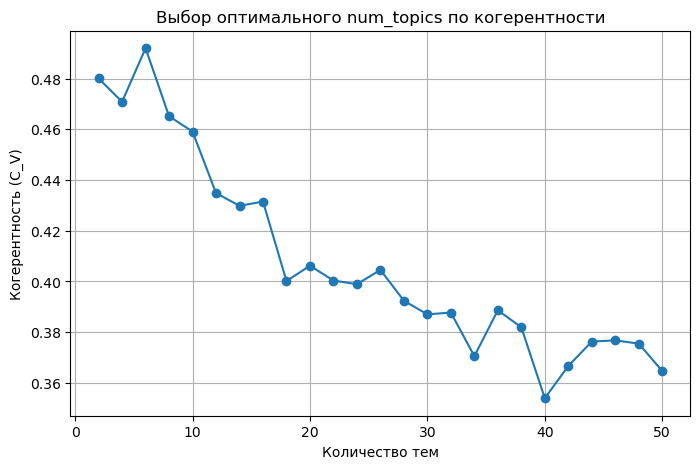

Оптимальное количество тем: 6


6

In [80]:
lda_model.find_optimal_num_topics(min_topics=2, max_topics=50, step=2)

In [81]:
lda_model.fit_transform(df[df.label == 'entertainment'], 'clean_text', num_topics=6)

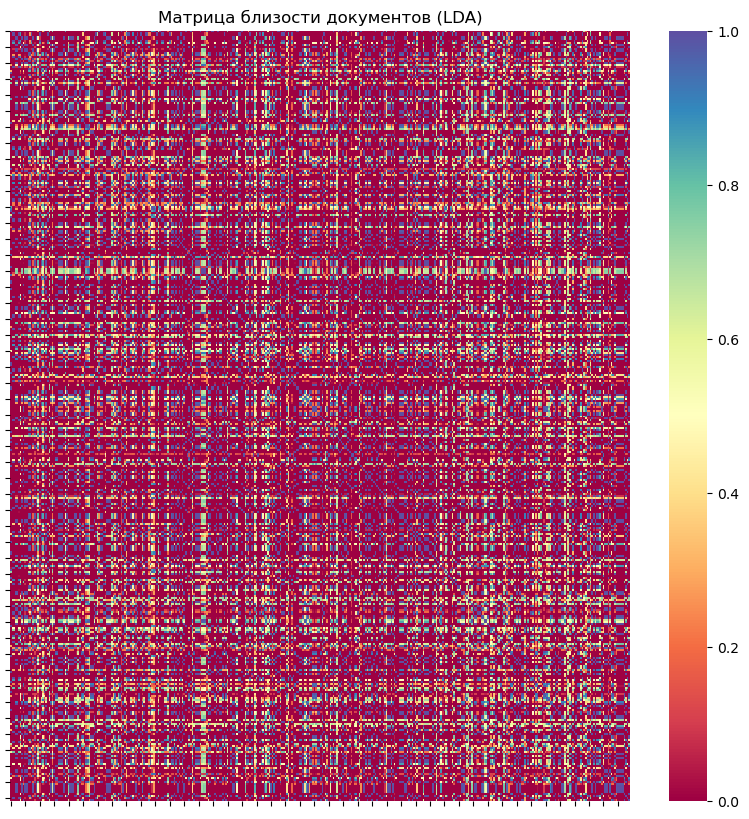

In [82]:
lda_model.plot_similarity()

Посмотрим на слова в некоторых темах:

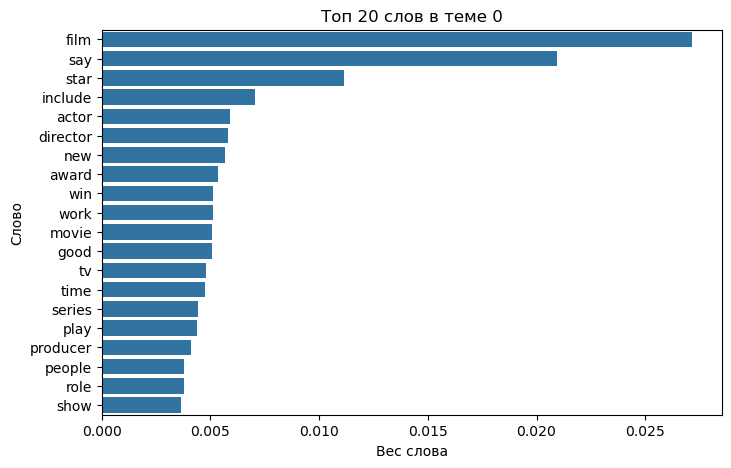

In [83]:
lda_model.plot_topic_keywords(topic_id=0, num_words=20)

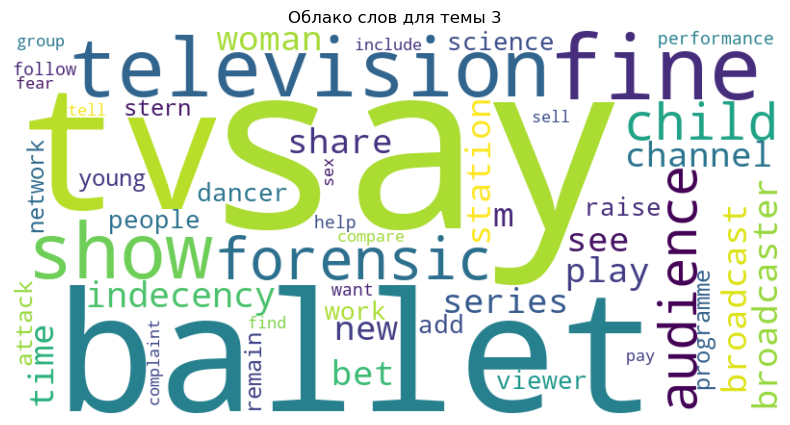

In [84]:
lda_model.plot_topic_wordcloud(topic_id=3, num_words=50)

#### Вывод:
1. Тема 0: Эта тема связана с фильмами, актерами, режиссерами, съемками и индустрией кино в целом.

2. Тема 1: Музыкальные награды и победители.

3. Тема 2: Киноиндустрия и награды. Эта тема также связана с кино, но с акцентом на награды, премии, кассовые сборы.

4. Тема 3: Тема связана с телевидением, телешоу, сериалами, зрителями, а также обсуждением телевизионных программ и их рейтингов.

5. Тема 4: Концерты и музыкальные фестивали, живые выступления.

6. Тема 5: Музыкальные хиты, популярность и продажи.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Sport. LDA</h4>
</div>

In [98]:
#Выделим в отдельный метод вызов класса
def print_result_lda(df, label, feature):
    lda_model = LdaTopicModeling()
    lda_model.prepare_corpus(df[df.label == label], feature)
    num_topics = lda_model.find_optimal_num_topics(min_topics=2, max_topics=15, step=1)
    lda_model.fit_transform(df[df.label == label], feature, num_topics=num_topics)
    print('Посмотрим на слова в некоторых темах:')
    lda_model.plot_topic_keywords(topic_id=0, num_words=20)
    lda_model.plot_topic_wordcloud(topic_id=1, num_words=50)
    lda_model.print_keywords(num_words=50)

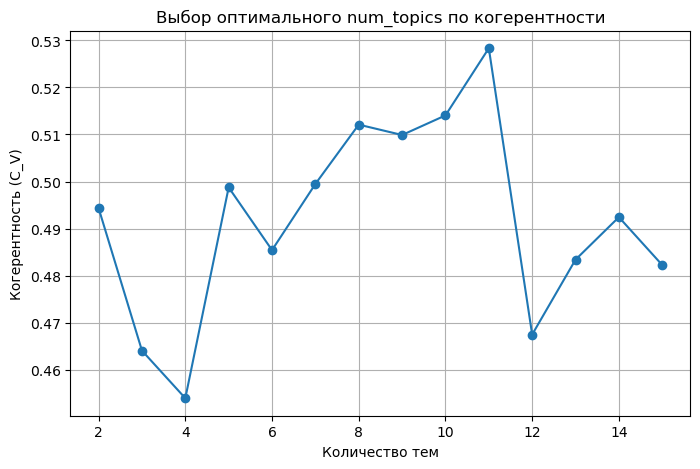

Оптимальное количество тем: 11
Посмотрим на слова в некоторых темах:


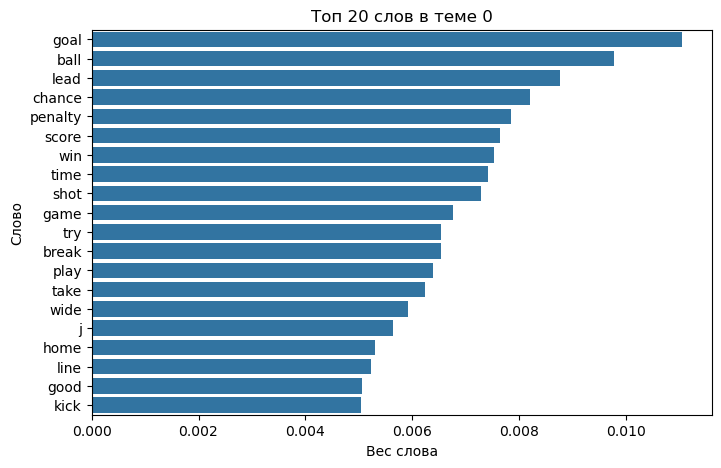

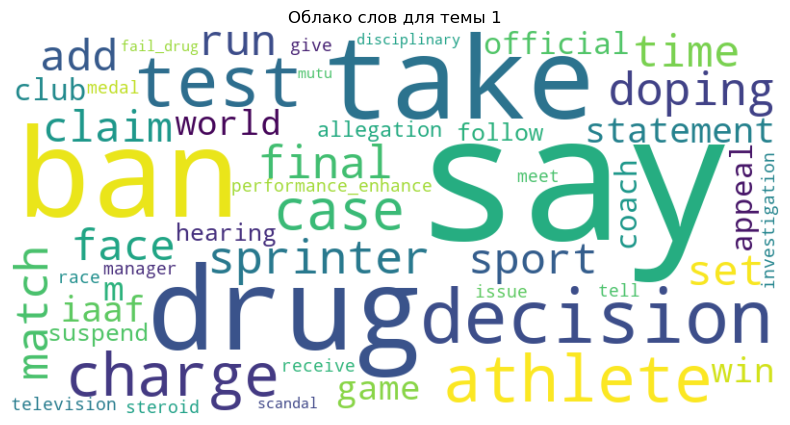

Тема 0: ('goal', 'ball', 'lead', 'chance', 'penalty', 'score', 'win', 'time', 'shot', 'game', 'try', 'break', 'play', 'take', 'wide', 'j', 'home', 'line', 'good', 'kick', 'sub', 'centre', 'start', 'cross', 'head', 'give', 'save', 'victory', 'm', 'right', 'point', 'miss', 'header', 's', 'free_kick', 'visitor', 'go', 'corner', 'pass', 'away', 'half', 'b', 'post', 'see', 'ahead', 'strike', 'bath', 'forward', 'd', 'send')
Тема 1: ('say', 'ban', 'drug', 'take', 'decision', 'test', 'athlete', 'charge', 'case', 'sprinter', 'doping', 'match', 'final', 'time', 'face', 'claim', 'sport', 'set', 'run', 'add', 'statement', 'iaaf', 'world', 'game', 'm', 'win', 'official', 'club', 'appeal', 'coach', 'hearing', 'suspend', 'follow', 'allegation', 'performance_enhance', 'steroid', 'race', 'medal', 'issue', 'give', 'investigation', 'television', 'tell', 'meet', 'manager', 'receive', 'disciplinary', 'scandal', 'mutu', 'fail_drug')
Тема 2: ('player', 'say', 'break', 'lead', 'match', 'try', 'penalty', 'play

In [86]:
print_result_lda(df, 'sport', 'clean_text' )

#### Вывод:
 - Тема 0: Футбол – тактика, голы и игровые моменты.
 - Тема 1: Допинг, дисквалификации и спортивные скандалы.
 - Тема 2: Международные турниры и клубные соревнования.
 - Тема 3: Регби – стратегии, тренеры и травмы.
 - Тема 4: Теннис и футбол.
 - Тема 5: Спортивные контракты, тренировки и карьерные решения.
 - Тема 6: Легкая атлетика, Олимпийские виды спорта.
 - Тема 7: Общий спортивный контекст.
 - Тема 8: Турниры регби.
 - Тема 9: Допинг и санкции.
 - Тема 10: Турниры по теннису и их обсуждение.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Tech. LDA</h4>
</div>

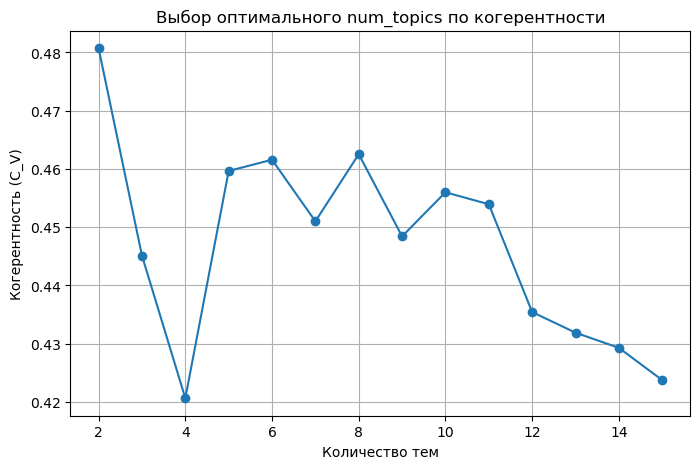

Оптимальное количество тем: 2
Посмотрим на слова в некоторых темах:


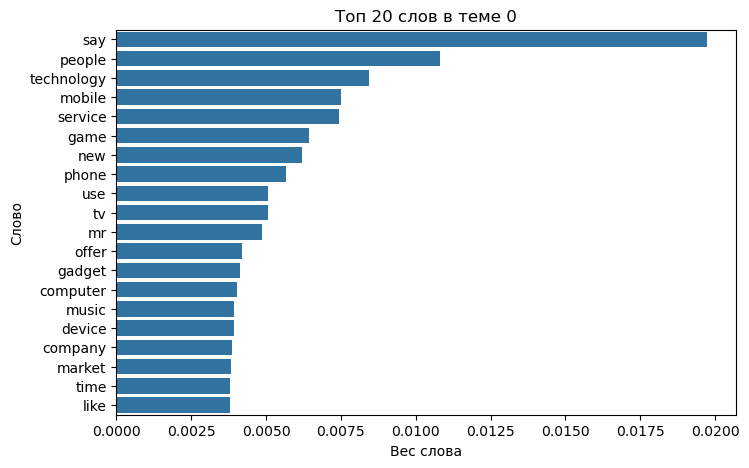

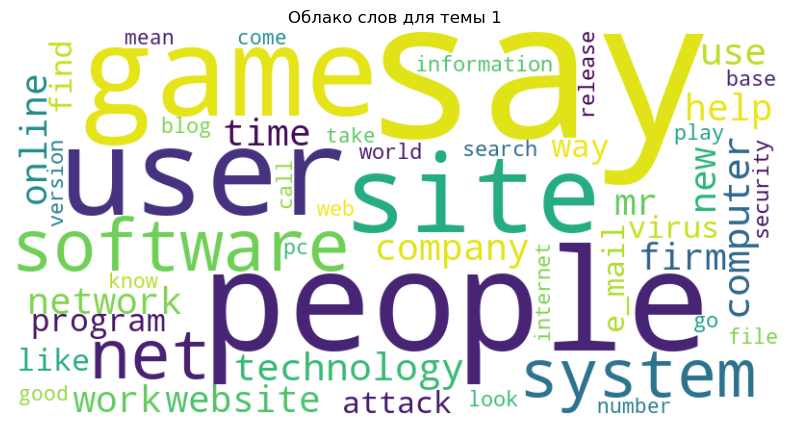

Тема 0: ('say', 'people', 'technology', 'mobile', 'service', 'game', 'new', 'phone', 'use', 'tv', 'mr', 'offer', 'gadget', 'computer', 'music', 'device', 'company', 'market', 'time', 'like', 'way', 'user', 'work', 'firm', 'player', 'broadband', 'pc', 'number', 'want', 'mobile_phone', 'net', 'consumer', 'launch', 'need', 'digital', 'home', 'video', 'network', 'sell', 'mean', 'set', 'world', 'play', 'content', 'add', 'come', 'industry', 'customer', 'call', 'big')
Тема 1: ('say', 'people', 'game', 'user', 'site', 'software', 'net', 'system', 'technology', 'computer', 'use', 'work', 'firm', 'new', 'network', 'online', 'company', 'website', 'mr', 'help', 'time', 'program', 'way', 'e_mail', 'like', 'virus', 'find', 'attack', 'information', 'web', 'file', 'world', 'blog', 'security', 'play', 'base', 'look', 'search', 'pc', 'internet', 'go', 'call', 'release', 'version', 'number', 'mean', 'take', 'know', 'good', 'come')


In [87]:
print_result_lda(df, 'tech', 'clean_text' )

#### Вывод:
 - Тема 0: Мобильные технологии, устройства и цифровые сервисы.
 - Тема 1: Интернет, программное обеспечение и кибербезопасность.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Politics. LDA</h4>
</div>

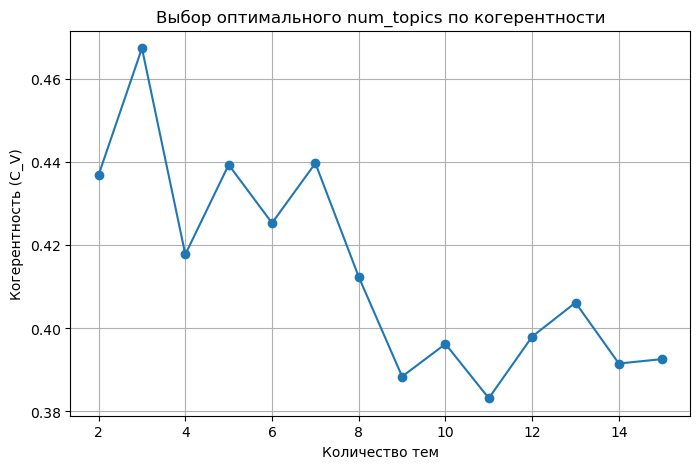

Оптимальное количество тем: 3
Посмотрим на слова в некоторых темах:


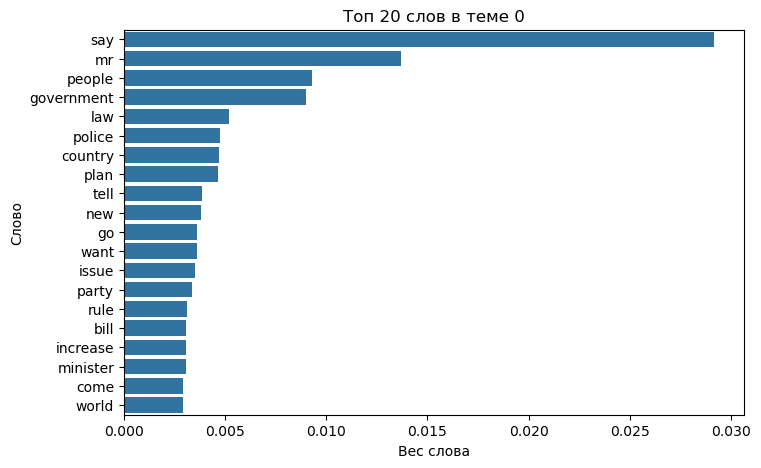

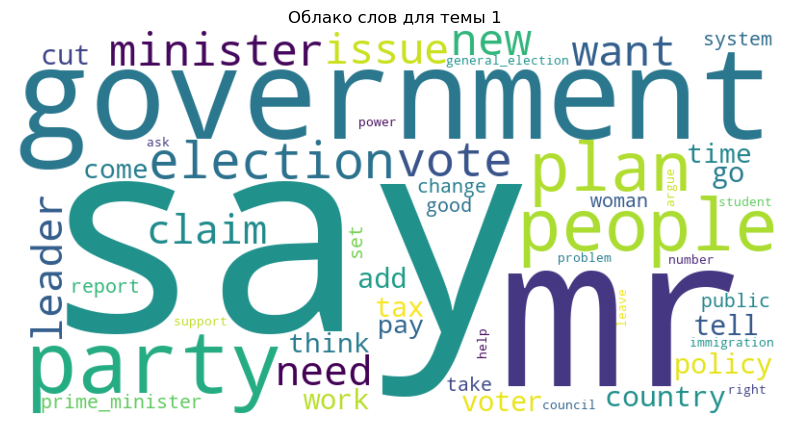

Тема 0: ('say', 'mr', 'people', 'government', 'law', 'police', 'country', 'plan', 'tell', 'new', 'go', 'want', 'issue', 'party', 'rule', 'bill', 'increase', 'minister', 'come', 'world', 'time', 'ban', 'need', 'power', 'add', 'think', 'right', 'hold', 'allow', 'call', 'pay', 'believe', 'evidence', 'way', 'group', 'man', 'attack', 'leader', 'human_right', 'work', 'hunt', 'id_card', 'use', 'case', 'decision', 'report', 'change', 'terrorist', 'trial', 'chancellor')
Тема 1: ('say', 'mr', 'government', 'party', 'people', 'plan', 'election', 'vote', 'minister', 'new', 'want', 'issue', 'leader', 'claim', 'need', 'country', 'tax', 'cut', 'go', 'policy', 'voter', 'work', 'tell', 'add', 'think', 'come', 'time', 'pay', 'prime_minister', 'change', 'report', 'public', 'set', 'good', 'take', 'woman', 'system', 'general_election', 'support', 'ask', 'council', 'immigration', 'power', 'help', 'number', 'right', 'problem', 'argue', 'leave', 'student')
Тема 2: ('say', 'mr', 'party', 'election', 'governmen

In [88]:
print_result_lda(df, 'politics', 'clean_text' )

#### Вывод:
 - Тема 0: Законы, правительство и борьба с преступностью.
 - Тема 1: Выборы, политика и налоги.
 - Тема 2: Политическая борьба и предвыборные кампании.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Business. LDA</h4>
</div>

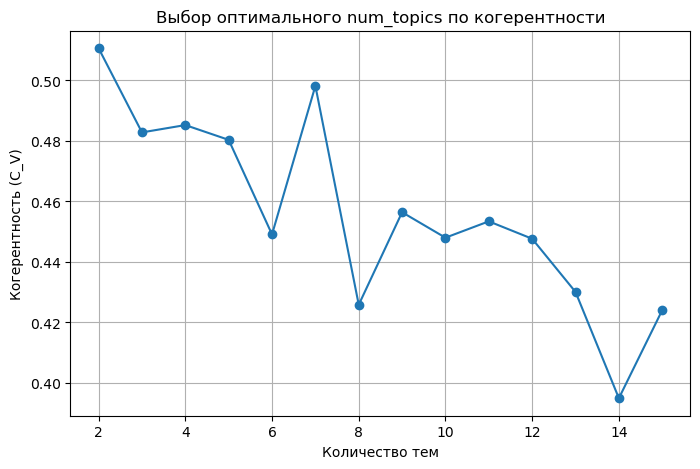

Оптимальное количество тем: 2
Посмотрим на слова в некоторых темах:


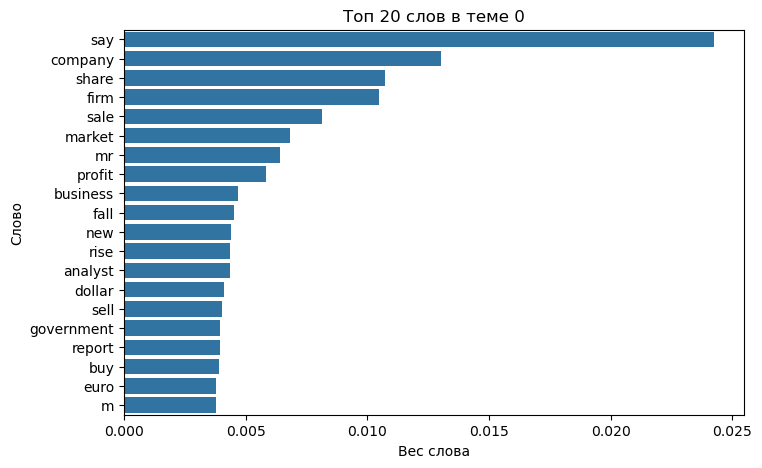

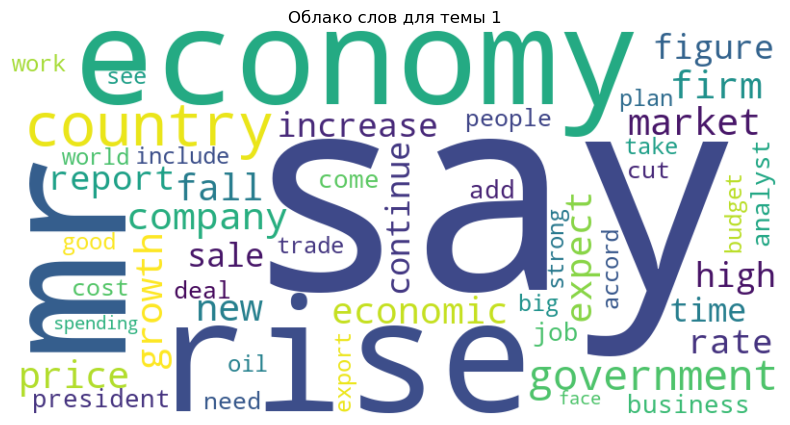

Тема 0: ('say', 'company', 'share', 'firm', 'sale', 'market', 'mr', 'profit', 'business', 'fall', 'new', 'rise', 'analyst', 'dollar', 'sell', 'government', 'report', 'buy', 'euro', 'm', 'deal', 'expect', 'group', 'price', 'bank', 'plan', 'offer', 'big', 'growth', 'increase', 'hit', 'chief_executive', 'large', 'car', 'demand', 'time', 'investor', 'cost', 'value', 'result', 'financial', 'oil', 'high', 'country', 'take', 'close', 'shareholder', 'see', 'add', 'cut')
Тема 1: ('say', 'mr', 'rise', 'economy', 'country', 'government', 'company', 'firm', 'growth', 'new', 'price', 'market', 'economic', 'expect', 'fall', 'report', 'rate', 'figure', 'high', 'increase', 'continue', 'sale', 'time', 'president', 'add', 'come', 'analyst', 'job', 'business', 'deal', 'people', 'cost', 'need', 'cut', 'big', 'see', 'accord', 'good', 'oil', 'plan', 'world', 'export', 'budget', 'work', 'strong', 'take', 'trade', 'include', 'spending', 'face')


In [89]:
print_result_lda(df, 'business', 'clean_text' )

#### Вывод:
 - Тема 0: Финансовые рынки, инвестиции.
 - Тема 1: Макроэкономика, государственная политика и мировая экономика.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Entertainment. LDA v2</h4>
</div>

В первом варианте видим очень много нейтральных слов, таких как say, tell, call. Попробуем их удалить и попробуем еще раз.

In [90]:
def preprocess_text(text, lemmatize=True):
    # Токенизация
    words = word_tokenize(text)
    # Удаление кастомных стоп-слов
    words = [word for word in words if word not in custom_stopwords]
    return ' '.join(words)

In [91]:
custom_stopwords = set(stopwords.words('english'))
custom_stopwords.update(["say", "new", "good", "people", "like", "time", "think", 
                         "get", "go", "come", "make", "know", "mr", "take", "year", 
                         "see", "work", "use", "want", "need", "give", "include", 
                         "way", "day", "many", "big", "right", "world", "find", "place", 
                         "part", "case", "tell", "thing", "set", "show", "back", "mean", 
                         "little", "try", "call", "long", "great", "number", "put", "look", 
                         "seem", "help", "run", "small", "hold", "turn", "name",
                         "company", "user", "firm", "player", "base", "group", "industry", "system",
                         "member", "support", "issue", "public", "leader", "add", "programme", "plan",
                         "match", "team", "game", "win", "play", "lose", "victory", "add"])

In [92]:
df['clean_text2'] = df['clean_text'].apply(lambda x: preprocess_text(x))

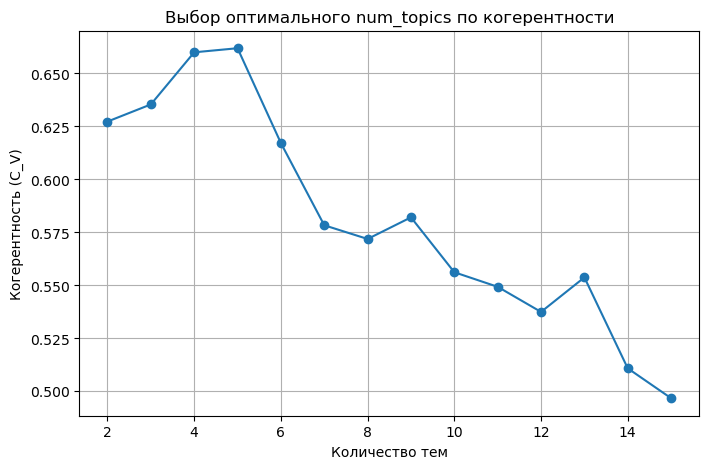

Оптимальное количество тем: 5
Посмотрим на слова в некоторых темах:


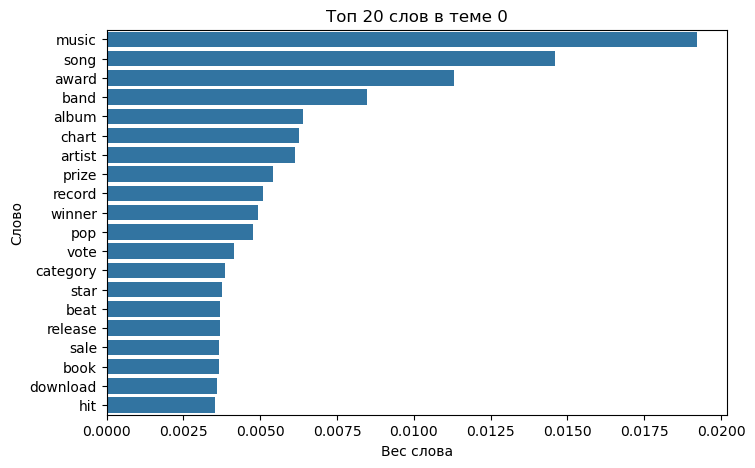

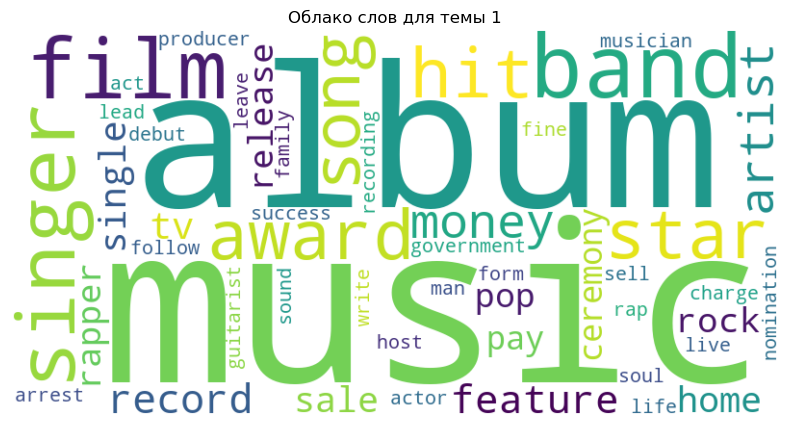

Тема 0: ('music', 'song', 'award', 'band', 'album', 'chart', 'artist', 'prize', 'record', 'winner', 'pop', 'vote', 'category', 'star', 'beat', 'release', 'sale', 'book', 'download', 'hit', 'urban', 'singer', 'act', 'tv', 'family', 'black', 'single', 'follow', 'write', 'film', 'live', 'list', 'rock', 'well', 'nomination', 'success', 'novel', 'fan', 'international', 'studio', 'musical', 'digital', 'life', 'honour', 'popular', 'feature', 'role', 'feel', 'country', 'female')
Тема 1: ('music', 'album', 'band', 'film', 'singer', 'award', 'hit', 'star', 'song', 'money', 'artist', 'record', 'feature', 'tv', 'single', 'home', 'sale', 'rapper', 'release', 'rock', 'pop', 'ceremony', 'pay', 'government', 'live', 'sell', 'leave', 'lead', 'arrest', 'producer', 'musician', 'man', 'act', 'soul', 'actor', 'follow', 'success', 'host', 'nomination', 'sound', 'life', 'rap', 'debut', 'charge', 'fine', 'write', 'family', 'form', 'guitarist', 'recording')
Тема 2: ('album', 'band', 'music', 'singer', 'song', 

In [99]:
print_result_lda(df, 'entertainment', 'clean_text2' )

#### Вывод:
Получили более четкое разделение на две темы:
 - Тема 0: Кино — ориентировано на премии и кассовый успех фильмов.
 - Тема 1: Музыка — акцент на чарты, продажи, выступления артистов.

Но, все таки, первый вариант на мой взгляд был лучше.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Business. LDA v2</h4>
</div>

В первом варианте получили 2 очень общих темы, при этом на графике оптимального числа тем возможно 7 даст хорошие результаты.

In [100]:
lda_model = LdaTopicModeling()

In [101]:
lda_model.prepare_corpus(df[df.label == 'business'], 'clean_text')

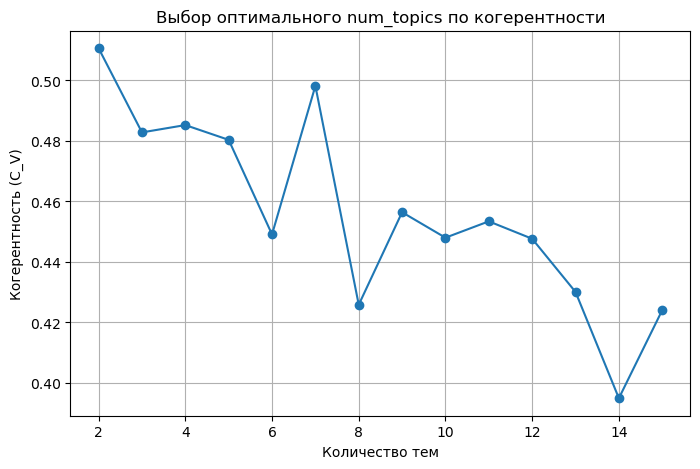

Оптимальное количество тем: 2


In [102]:
num_topics = lda_model.find_optimal_num_topics(min_topics=2, max_topics=15, step=1)

In [103]:
lda_model.fit_transform(df[df.label == 'business'], 'clean_text', num_topics=7)

In [104]:
lda_model.print_keywords(num_words=50)

Тема 0: ('say', 'share', 'company', 'firm', 'sale', 'profit', 'market', 'business', 'analyst', 'euro', 'mr', 'fall', 'expect', 'hit', 'government', 'rise', 'offer', 'increase', 'cost', 'plan', 'm', 'buy', 'group', 'new', 'sell', 'dollar', 'big', 'growth', 'report', 'industry', 'price', 'close', 'country', 'cut', 'car', 'revenue', 'lose', 'high', 'economic', 'investor', 'economy', 'result', 'demand', 'low', 'large', 'see', 'financial', 'add', 'stock_market', 'chief_executive')
Тема 1: ('say', 'mr', 'sale', 'new', 'firm', 'company', 'rise', 'price', 'deal', 'offer', 'bid', 'expect', 'government', 'market', 'report', 'airline', 'analyst', 'country', 'oil', 'high', 'add', 'business', 'see', 'cut', 'production', 'continue', 'plan', 'shareholder', 'share', 'include', 'lead', 'figure', 'm', 'base', 'take', 'come', 'profit', 'boost', 'big', 'large', 'industry', 'number', 'need', 'demand', 'buy', 'cost', 'flight', 'store', 'order', 'job')
Тема 2: ('say', 'growth', 'economy', 'rise', 'rate', 'fa

#### Выводы:
 - Тема 0: Фондовые рынки, акции и инвестиции.
 - Тема 1: Корпоративные сделки, поглощения и инвестиции.
 - Тема 2: Макроэкономика, ВВП и инфляция.
 - Тема 3: Международная торговля и валютные рынки.
 - Тема 4: Финансовый сектор и банки.
 - Тема 5: Корпоративные скандалы, мошенничество и судебные дела.
 - Тема 6: Судебные процессы, банкротства и корпоративные конфликты.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Tech LDA v2</h4>
</div>

В первом варианте получили 2 очень общих темы, при этом на графике оптимального числа тем возможно 8 даст хорошие результаты.

In [105]:
lda_model = LdaTopicModeling()

In [106]:
lda_model.prepare_corpus(df[df.label == 'tech'], 'clean_text')

In [107]:
lda_model.fit_transform(df[df.label == 'tech'], 'clean_text', num_topics=8)

In [108]:
lda_model.print_keywords(num_words=50)

Тема 0: ('say', 'service', 'tv', 'mobile', 'broadband', 'people', 'net', 'offer', 'game', 'technology', 'new', 'firm', 'content', 'like', 'phone', 'network', 'programme', 'fast', 'way', 'report', 'user', 'video', 'time', 'set', 'need', 'number', 'home', 'online', 'digital', 'operator', 'standard', 'broadcast', 'computer', 'mr', 'company', 'access', 'launch', 'channel', 'consumer', 'customer', 'see', 'grow', 'mean', 'big', 'find', 'get', 'speed', 'analyst', 'industry', 'want')
Тема 1: ('say', 'game', 'site', 'attack', 'blog', 'people', 'play', 'net', 'time', 'network', 'website', 'online', 'computer', 'work', 'datum', 'spam', 'get', 'way', 'e_mail', 'information', 'traffic', 'technology', 'user', 'mr', 'campaign', 'use', 'system', 'look', 'web', 'internet', 'problem', 'like', 'company', 'send', 'blogger', 'know', 'call', 'world', 'go', 'access', 'start', 'firm', 'spammer', 'good', 'find', 'base', 'service', 'help', 'pc', 'think')
Тема 2: ('say', 'user', 'people', 'software', 'system', '

#### Выводы:
 - Тема 0: Телекоммуникации, телевидение и интернет-провайдеры.
 - Тема 1: Киберугрозы, хакерские атаки и безопасность в интернете.
 - Тема 2: Разработка программного обеспечения и IT-системы.
 - Тема 3: Беспроводные технологии и умные устройства.
 - Тема 4: Игровая индустрия.
 - Тема 5: Мобильные телефоны и их экосистема.
 - Тема 6: Аудио- и видеоустройства, мультимедиа.
 - Тема 7: Веб-браузеры и интернет-сервисы.